 ## Notebook: Image Recognition - Multiple Attributes 


* This dataset  do not allow to work with the "flow_from_directory" method of keras, as the images need to be on different folders depending the target and type of data (train, validation, test). For this I am working with the "flow" method.
* Memory limitation, so I am using a reduced amount of images to train and validate.

### Now let´s start

Image recognition is one of the many applications of Machine Learning, it can solve problems for security purposes, object detection, face detection, healthcare, entertainment, among others. This application has an enormous potential to help our society, so it is important to find new uses for this tool, improve the current methods and get more accurate and useful insights from it. A good example of these applications, is the work done by research of The Chinese University of Hong Kong for face detection using deep learning (https://arxiv.org/abs/1509.06451).

In this project, we will build a Machine Learning Algorithm using CNN to predict from a giving picture if the celebrity is male or female.



## Dataset

For this project we will use the CelebA dataset (http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

Description of the CelebA dataset from kaggle (https://www.kaggle.com/jessicali9530/celeba-dataset): 

### Context

A popular component of computer vision and deep learning revolves around identifying faces for various applications from logging into your phone with your face or searching through surveillance images for a particular suspect. This dataset is great for training and testing models for face detection, particularly for recognising facial attributes such as finding people with brown hair, are smiling, or wearing glasses. Images cover large pose variations, background clutter, diverse people, supported by a large quantity of images and rich annotations. This data was originally collected by researchers at MMLAB, The Chinese University of Hong Kong (specific reference in Acknowledgment section).

### Content

#### Overall

202,599 number of face images of various celebrities
10,177 unique identities, but names of identities are not given
40 binary attribute annotations per image
5 landmark locations

#### Data Files

- <b>img_align_celeba.zip</b>: All the face images, cropped and aligned
- <b>list_eval_partition.csv</b>: Recommended partitioning of images into training, validation, testing sets. Images 1-162770 are training, 162771-182637 are validation, 182638-202599 are testing
- <b>list_bbox_celeba.csv</b>: Bounding box information for each image. "x_1" and "y_1" represent the upper left point coordinate of bounding box. "width" and "height" represent the width and height of bounding box
- <b>list_landmarks_align_celeba.csv</b>: Image landmarks and their respective coordinates. There are 5 landmarks: left eye, right eye, nose, left mouth, right mouth
- <b>list_attr_celeba.csv</b>: Attribute labels for each image. There are 40 attributes. "1" represents positive while "-1" represents negative

---


 ### Import libraries

In [1]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from keras.optimizers import SGD

from IPython.core.display import display, HTML
from PIL import Image
from io import BytesIO
import base64

plt.style.use('ggplot')

%matplotlib inline

In [2]:
import tensorflow as tf
print(tf.__version__)

2.3.1


## Step 1: Data Exploration

We will be using the CelebA Dataset, which includes images of 178 x 218 px. Below is an example of how the pictures looks like.

In [3]:
# set variables 
main_folder = 'C:/Users/tarun/Desktop/Artificial Intelligence/Algorithms/Capstone/Data/'
images_folder = main_folder + 'img_align_celeba'

EXAMPLE_PIC = images_folder + '/000506.jpg'

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 178
IMG_HEIGHT = 218
BATCH_SIZE = 16
NUM_EPOCHS = 20

print(EXAMPLE_PIC)

C:/Users/tarun/Desktop/Artificial Intelligence/Algorithms/Capstone/Data/img_align_celeba/000506.jpg


### Load the attributes of every picture
File: list_attr_celeba.csv

In [4]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
df_attr.set_index('image_id', inplace=True)
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(202599, 40)

 ### List of the available attribute in the CelebA dataset

40 Attributes

In [5]:
# List of available attributes
for i, j in enumerate(df_attr.columns):
    print(i, j)

0 5_o_Clock_Shadow
1 Arched_Eyebrows
2 Attractive
3 Bags_Under_Eyes
4 Bald
5 Bangs
6 Big_Lips
7 Big_Nose
8 Black_Hair
9 Blond_Hair
10 Blurry
11 Brown_Hair
12 Bushy_Eyebrows
13 Chubby
14 Double_Chin
15 Eyeglasses
16 Goatee
17 Gray_Hair
18 Heavy_Makeup
19 High_Cheekbones
20 Male
21 Mouth_Slightly_Open
22 Mustache
23 Narrow_Eyes
24 No_Beard
25 Oval_Face
26 Pale_Skin
27 Pointy_Nose
28 Receding_Hairline
29 Rosy_Cheeks
30 Sideburns
31 Smiling
32 Straight_Hair
33 Wavy_Hair
34 Wearing_Earrings
35 Wearing_Hat
36 Wearing_Lipstick
37 Wearing_Necklace
38 Wearing_Necktie
39 Young


 ### Example of a picture in CelebA dataset
178 x 218 px

Smiling    1
Male       0
Young      1
Name: 000506.jpg, dtype: int64

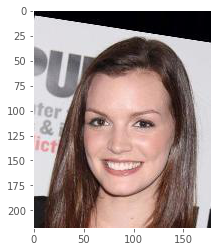

In [6]:
# plot picture and attributes
img = load_img(EXAMPLE_PIC)
plt.grid(False)
plt.imshow(img)
df_attr.loc[EXAMPLE_PIC.split('/')[-1]][['Smiling','Male','Young']] #some attributes

 ### Distribution of the Attribute

As specified before, this Notebook is an imagine recognition project of the Gender. There are more Female gender than Male gender in the data set. This give us some insight about the need to balance the data in next steps.

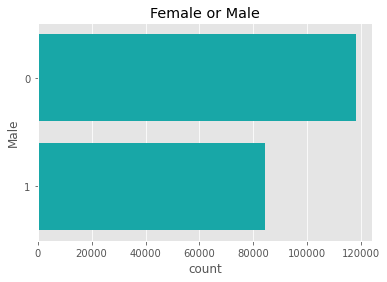

In [7]:
# Female or Male?
plt.title('Female or Male')
sns.countplot(y='Male', data=df_attr, color="c")
plt.show()

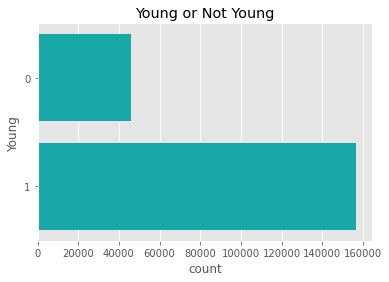

In [8]:
# Female or Male?
plt.title('Young or Not Young')
sns.countplot(y='Young', data=df_attr, color="c")
plt.show()

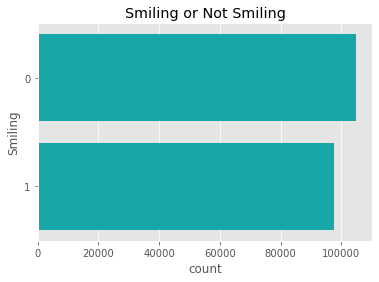

In [9]:
# Female or Male?
plt.title('Smiling or Not Smiling')
sns.countplot(y='Smiling', data=df_attr, color="c")
plt.show()

## Step 2: Split Dataset into Training, Validation and Test

The recommended partitioning of images into training, validation, testing of the data set is: 
* 1-162770 are training
* 162771-182637 are validation
* 182638-202599 are testing

The partition is in file <b>list_eval_partition.csv</b>

Due time execution, by now we will be using a reduced number of images:

* Training 20000 images
* Validation 5000 images
* Test 5000 Images


In [10]:
# Recomended partition
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [11]:
# display counter by partition
# 0 -> TRAINING
# 1 -> VALIDATION
# 2 -> TEST
df_partition['partition'].value_counts().sort_index()

0    162770
1     19867
2     19962
Name: partition, dtype: int64

 #### Join the partition and the attributes in the same data frame

In [12]:
# join the partition with the attributes
df_partition.set_index('image_id', inplace=True)
df_par_attr = df_partition.join(df_attr['Male'], how='inner')
df_par_attr.head()

,partition,Male
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,0,1
000004.jpg,0,0
000005.jpg,0,0


### 2.1: Generate Partitions (Train, Validation, Test)

Number of images need to be balanced in order to get a good performance for the model, each model will have its own folder of training, validation and test balanced data.

This degree project explains how imbalanced training data impact on CNNs models:

https://www.kth.se/social/files/588617ebf2765401cfcc478c/PHensmanDMasko_dkand15.pdf

On this step we will create functions that will help us to create each partition.

In [14]:
def load_reshape_img(fname):
    img = load_img(fname)
    x = img_to_array(img)/255.
    x = x.reshape((1,) + x.shape)

    return x


def generate_df(partition, attr, num_samples):
    '''
    partition
        0 -> train
        1 -> validation
        2 -> test
    
    '''
    
    df_ = df_par_attr[(df_par_attr['partition'] == partition) 
                           & (df_par_attr[attr] == 0)].sample(int(num_samples/2))
    df_ = pd.concat([df_,
                      df_par_attr[(df_par_attr['partition'] == partition) 
                                  & (df_par_attr[attr] == 1)].sample(int(num_samples/2))])

    # for Train and Validation
    if partition != 2:
        x_ = np.array([load_reshape_img(images_folder + fname) for fname in df_.index])
        x_ = x_.reshape(x_.shape[0], 218, 178, 3)
        y_ = np_utils.to_categorical(df_[attr],2)
    # for Test
    else:
        x_ = []
        y_ = []

        for index, target in df_.iterrows():
            im = cv2.imread(images_folder + index)
            im = cv2.resize(cv2.cvtColor(im, cv2.COLOR_BGR2RGB), (IMG_WIDTH, IMG_HEIGHT)).astype(np.float32) / 255.0
            im = np.expand_dims(im, axis =0)
            x_.append(im)
            y_.append(target[attr])

    return x_, y_

 ## Step 3: Pre-processing Images: Data Augmentation

Generates Data Augmentation for iamges.

Data Augmentation allows to generate images with modifications to the original ones. The model will learn from these variations (changing angle, size and position), being able to predict better never seen images that could have the same variations in position, size and position.

### 3.1. Let's start with an example: Data Augmentation

This is how an image will look like after data augmentation (based in the giving parameters below).

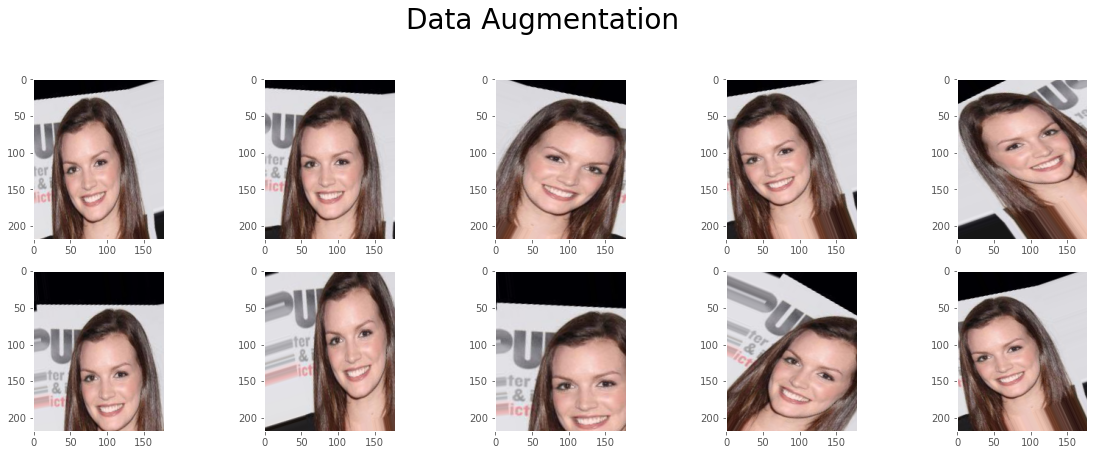

In [15]:
# Generate image generator for data augmentation
datagen =  ImageDataGenerator(
  #preprocessing_function=preprocess_input,
  rotation_range=30,
  width_shift_range=0.2,
  height_shift_range=0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

# load one image and reshape
img = load_img(EXAMPLE_PIC)
x = img_to_array(img)/255.
x = x.reshape((1,) + x.shape)

# plot 10 augmented images of the loaded iamge
plt.figure(figsize=(20,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.subplot(3, 5, i+1)
    plt.grid(False)
    plt.imshow( batch.reshape(218, 178, 3))
    
    if i == 9:
        break
    i += 1
    
plt.show()

The result is a new set of images with modifications from the original one, that allows to the model to learn from these variations in order to take this kind of images during the learning process and predict better never seen images.